# Text-to-SQL Chain with Query Examples, Table Descriptions, and Table Context
### DB: AWS S3
### SQL: AWS Athena
### Chat History Storage: AWS DynamoDB
### Vector Store: FAISS
### LLM: GPT-3.5

## Chain:

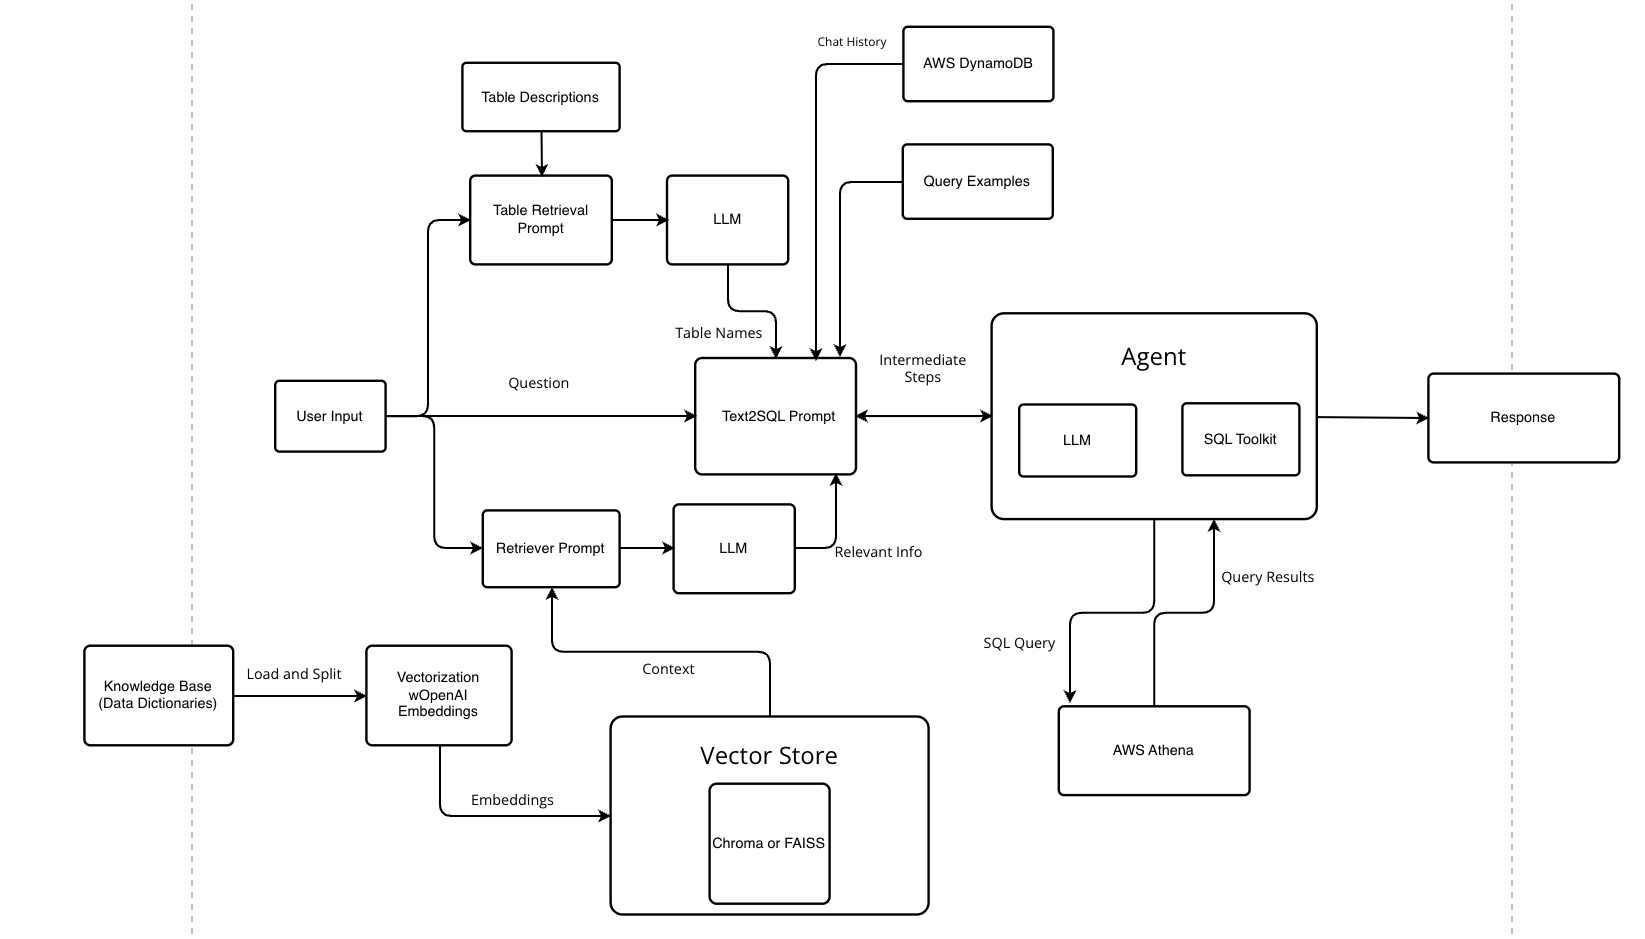

In [1]:
import getpass
import os

#set environmental variable for OpenAI API key
os.environ["OPENAI_API_KEY"] = getpass.getpass()

 ········


In [3]:
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="langchainllmproject"
os.environ["LANGCHAIN_ENDPOINT"]= "https://api.smith.langchain.com" 
os.environ["LANGCHAIN_API_KEY"]="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"

#### set up AWS DynamoDB for Chat History

In [2]:
import boto3
from langchain_community.chat_message_histories import (
    DynamoDBChatMessageHistory,
)

#set up dynamodb
dynamodb = boto3.resource("dynamodb")

#create composite key (session id & user id) for accessing databases
composite_key = {
    "SessionId": "session_id::19",
    "UserID": "0001",
}

#query DynamoDB for chat history using the composite key
chat_history = DynamoDBChatMessageHistory(
    table_name = "Chat_Table",
    session_id = "0",
    key = composite_key,
    history_size = 6,
)

#### set up AWS S3 and Athena for Database Access

In [3]:
from sqlalchemy import create_engine
from urllib.parse import quote_plus
from langchain_community.utilities import SQLDatabase

#database info
AWS_REGION = "us-east-1"
SCHEMA_NAME = "wnba_db"
S3_STAGING_DIR = "s3://wnbadata/"

connect_str = "awsathena+rest://athena.{region_name}.amazonaws.com:443/{schema_name}?s3_staging_dir={s3_staging_dir}"

#connect to AWS athena
engine = create_engine(connect_str.format(
        region_name=AWS_REGION,
        schema_name=SCHEMA_NAME,
        s3_staging_dir=quote_plus(S3_STAGING_DIR)
))

#create SQL db object
db = SQLDatabase(engine)

#fetch table schema
schema = db.get_table_info()

/var/folders/1c/ybx_8cds1ybgdg3z19ptmmk00000gn/T/ipykernel_95480/3266133602.py:13: SADeprecationWarning: The dbapi() classmethod on dialect classes has been renamed to import_dbapi().  Implement an import_dbapi() classmethod directly on class <class 'pyathena.sqlalchemy.rest.AthenaRestDialect'> to remove this warning; the old .dbapi() classmethod may be maintained for backwards compatibility.
  engine = create_engine(connect_str.format(


#### Load Query Examples from JSON file

In [4]:
import json

#load query examples from json
f = open("src/query_example.json")
query_examples_json = json.load(f)

examples = query_examples_json["query_examples"]

In [5]:
file_paths = ["src/wnba_nba_pbp_data_dict.json", "src/wnba_player_box.json", "src/wnba_player_info.json", "src/wnba_schedule.json", "src/wnba_teambox.json"]

#### Load Table Names and Descriptions from JSON file

In [6]:
def get_table_details():

    for file_path in file_paths:
        
        #load table names and descriptions from json
        f = open(file_path)
        table_dict = json.load(f)
        
        #retrieve table names and descriptions and compile into string
        table_details = ""
        table_details = table_details + "Table Name:" + table_dict['table_name'] + "\n" \
        + "Table Description:" + table_dict['table_description'] + "\n\n"

    '''
    f = open("src/wnba_nba_pbp_data_dict.json")
    pbp_dict = json.load(f)
    f = open("src/wnba_player_box.json")
    player_box_dict = json.load(f)
    f = open("src/wnba_player_info.json")
    player_info_dict = json.load(f)
    f = open("src/wnba_schedule.json")
    schedule_dict = json.load(f)
    f = open("src/wnba_teambox.json")
    team_box_dict = json.load(f)
    
    #retrieve table names and descriptions and compile into string
    table_details = ""
    table_details = table_details + "Table Name:" + pbp_dict['table_name'] + "\n" + "Table Description:" + pbp_dict['table_description'] + "\n\n"
    table_details = table_details + "Table Name:" + player_box_dict['table_name'] + "\n" + "Table Description:" + player_box_dict['table_description'] + "\n\n"
    table_details = table_details + "Table Name:" + player_info_dict['table_name'] + "\n" + "Table Description:" + player_info_dict['table_description'] + "\n\n"
    table_details = table_details + "Table Name:" + schedule_dict['table_name'] + "\n" + "Table Description:" + schedule_dict['table_description'] + "\n\n"
    table_details = table_details + "Table Name:" + team_box_dict['table_name'] + "\n" + "Table Description:" + team_box_dict['table_description'] + "\n\n"
    '''
    return table_details

#### Create Table Info Retrieval Chain

In [7]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

#Creating a Pydantic Base Model
class Table(BaseModel):
    """Table in SQL database."""

    name: str = Field(description = "Name of table in SQL database.")

table_details = get_table_details()

#create table chain prompt
table_prompt_system = f"""Refer the Above Context and Return the names of SQL Tables that MIGHT be relevant to the above context\n\n 
The tables are:

{table_details}
 """

table_details_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", table_prompt_system),
        ("human", "{input}"),
    ]
)

#set up LLM
table_chain_llm = ChatOpenAI(model_name= "gpt-3.5-turbo-0125", temperature= 0)
table_chain_llm_wtools = table_chain_llm.bind_tools([Table])
output_parser = PydanticToolsParser(tools=[Table])

#create table chain
table_chain = table_details_prompt | table_chain_llm_wtools | output_parser

#### create meta function for json loader

In [8]:
def metadata_func(record: dict, metadata: dict) -> dict:
    columns = record.get("values", [])

    # Extracting column details using list comprehension
    cname = [col.get("column_name") for col in columns]
    dtype = [col.get("column_type") for col in columns]
    cdesc = [col.get("column_description") for col in columns]

    metadata.update({
        "Table_Name": record.get("table_name"),
        "Table_Description": record.get("table_description"),
        "Column_Names": str(cname),
        "Column_Types": str(dtype),
        "Column_Descriptions": str(cdesc),
    })
    return metadata

### load all table dictionaries from json to docs

In [9]:
import jq
from langchain_community.document_loaders import JSONLoader
from langchain_community.document_loaders.merge import MergedDataLoader

loaders = []

for file_path in file_paths:
    loaders.append(JSONLoader(
        file_path=file_path,
        jq_schema='.',
        text_content=False,
        metadata_func=metadata_func
    )
                  )

loader_all = MergedDataLoader(loaders = loaders)
docs_all = loader_all.load()

### create embeddings and store to vector store

In [10]:
from langchain_community.vectorstores import FAISS
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

vector_db = FAISS.from_documents(docs_all, OpenAIEmbeddings())
#vector_db = Chroma.from_documents(docs_all, OpenAIEmbeddings())
retriever = vector_db.as_retriever()

### create table context retrieval chain

In [11]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


table_contex_llm = ChatOpenAI(model_name= "gpt-3.5-turbo-0125", temperature= 0)

table_context_template = """Answer the question based only on the following context:
    {context}
    Search for the table descriptions in the context and accordingly search for column names and associated column description. Include only relevant tables and columns which can be used by the downstream Text-to-SQL Agent to create SQL Queries for generating answer.
    Search for any information performing the following tasks:
    1. Table Names
    2. Table Descriptions
    3. Column Names
    4. Column Descriptions
    5. Column Types
    Finally, only return table names, column names and Column Types only (if availabe).

    Question: {question}
    """

table_context_prompt = ChatPromptTemplate.from_template(table_context_template)
    
context_retriever_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | table_context_prompt
    | table_contex_llm
    | StrOutputParser()
)

#### set up LLM, tools, agent, and prompt

In [12]:
from langchain.globals import set_debug
from langchain_core.prompts import MessagesPlaceholder
from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser
from langchain.agents import tool
from langchain.agents import AgentExecutor
from langchain_community.agent_toolkits import SQLDatabaseToolkit

#set up LLM
llm = ChatOpenAI(model_name= "gpt-3.5-turbo-0125", temperature= 0)
#utilize langchain agent toolkit: SQL toolkit
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()
llm_with_tools = llm.bind_tools(tools)

#create few shot prompt with query examples
example_prompt = ChatPromptTemplate.from_messages(["User input: {input}\nSQL query: {query}"])
few_shot_prompt = FewShotChatMessagePromptTemplate(
    examples = examples,
    example_prompt = example_prompt,
)

#create prompt for agent
prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are an agent designed to interact with a SQL database to answer questions about the WNBA.
        Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
        You should also leverage your pre-existing knowledge of WNBA rules, statistics, teams, players, and history to understand and interpret user questions and your answer accurately.
        Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
        You can order the results by a relevant column to return the most interesting examples in the database.
        Never query for all the columns from a specific table, only ask for the relevant columns given the question.
        You have access to tools for interacting with the database.
        Only use the below tools. Only use the information returned by the below tools to construct your final answer.
        Base your final answer solely on the information returned by these tools, combined with your existing knowledge of the WNBA.
        You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.
        
        DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
        
        To start you should ALWAYS look at the tables in the database to see what you can query.
        Do NOT skip this step.
        Then you should query the schema of the most relevant tables.
        Consider the relevant table names and table info below. Note that you may also consider other tables you think are necessary.
        {table_names_to_use}
        {table_context}
        """,
    ),
    few_shot_prompt,
    #message placeholder for chat history
    MessagesPlaceholder(variable_name = "chat_history"),
    ("user", "{input}"),
    #message placeholder for storing intermediate steps
    MessagesPlaceholder(variable_name = "agent_scratchpad"),
])

#create agent
agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        ),
        "chat_history": lambda x: x["chat_history"],
        "table_names_to_use": lambda x: x["table_names_to_use"],
        "table_context": lambda x: x["table_context"]
    }
    | prompt
    | llm_with_tools
    | OpenAIToolsAgentOutputParser()
)
agent_executor = AgentExecutor(agent = agent, tools = tools, verbose = False, return_intermediate_steps = True)

#### execution of text2sql chain

In [13]:
from langchain_core.messages import AIMessage, HumanMessage

input_text = input('>>> ')
while input_text.lower() != 'bye':
    if input_text:
        
        print("loading response....")
        
        response = agent_executor.invoke({
            "input": input_text,
            "chat_history": chat_history.messages,
            #passing result of table chain to text2sql agent
            "table_names_to_use": table_chain.invoke(input_text),
            #passing result of retrieval chain to text2sql agent
            "table_context": context_retriever_chain.invoke(input_text),
        })
        chat_history.add_user_message(input_text)
        chat_history.add_ai_message(response["output"])

        print("Response: " + response["output"])
    input_text = input('>>> ')

>>>  Which player scored the most points in a single game between 2018 and 2024?


loading response....
Response: The player who scored the most points in a single game between 2018 and 2024 was Liz Cambage with 53 points.


>>>  Which team had the highest average points per game in the 2021 season?


loading response....
Response: The team with the highest average points per game in the 2021 season was the Las Vegas Aces.


>>>  How many games ended in overtime during the 2023 season?


loading response....
Response: There were 12 games that ended in overtime during the 2023 season.


>>>  Which player had the highest free throw percentage in the 2020 season?


loading response....
Response: The player with the highest free throw percentage in the 2020 season was Arike Ogunbowale.


>>>  What was the win-loss record of the Seattle Storm in the 2022 season?


loading response....
Response: The win-loss record of the Seattle Storm in the 2022 season was 22 wins and 12 losses.


>>>  Which team had the longest winning streak in the 2019 season?


loading response....
Response: I encountered an error while trying to retrieve the team with the longest winning streak in the 2019 season. Unfortunately, the specific column for tracking winning streaks is not available in the database. If you have any other questions or need further information, feel free to ask.


>>>  How many triple-doubles were recorded in the WNBA between 2018 and 2024, and by which players?


loading response....


Failed to execute query.
Traceback (most recent call last):
  File "/Users/albertkao/anaconda3/envs/210envtest/lib/python3.11/site-packages/pyathena/common.py", line 575, in _execute
    query_id = retry_api_call(
               ^^^^^^^^^^^^^^^
  File "/Users/albertkao/anaconda3/envs/210envtest/lib/python3.11/site-packages/pyathena/util.py", line 84, in retry_api_call
    return retry(func, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/albertkao/anaconda3/envs/210envtest/lib/python3.11/site-packages/tenacity/__init__.py", line 475, in __call__
    do = self.iter(retry_state=retry_state)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/albertkao/anaconda3/envs/210envtest/lib/python3.11/site-packages/tenacity/__init__.py", line 376, in iter
    result = action(retry_state)
             ^^^^^^^^^^^^^^^^^^^
  File "/Users/albertkao/anaconda3/envs/210envtest/lib/python3.11/site-packages/tenacity/__init__.py", line 398, in <lambda>
    self._add_action_fun

Response: Between 2018 and 2024, Sabrina Ionescu recorded 4 triple-doubles, and Alyssa Thomas recorded 12 triple-doubles in the WNBA.


>>>  Which team had the best defense in the 2024 season (by opponent points)?


loading response....
Response: I encountered an error while trying to retrieve the team with the best defense in the 2024 season based on opponent points. Unfortunately, there was an issue with the query execution. If you have any other questions or need further information, please let me know.


>>>  Identify the game with the highest combined score (both teams) from 2018 to 2024.


loading response....
Response: I apologize for the inconvenience. It seems there is still a type mismatch issue in the query, which is preventing the retrieval of the game with the highest combined score. Unfortunately, I am unable to provide the specific game at this time. If you have any other questions or need further assistance, please feel free to let me know.


>>>  Which player played the most minutes in the 2021 season?


loading response....
Response: Skylar Diggins-Smith played the most minutes in the 2021 season, totaling 1440 minutes.


>>>  bye
